In [1]:
import pandas as pd
import numpy as np
import distython
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tidy_data = pd.read_csv('tidy.csv')
X_data = tidy_data.drop(['CHT_No', 'reStroke'], axis=1)
y_data = tidy_data[['reStroke']]
categorical_ix = [0, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 43, 44, 45,46, 48, 49, 50, 51, 52, 53, 55]
categorical_columns = X_data.columns[categorical_ix].values
numerical_columns =  np.setdiff1d(X_data.columns, categorical_columns)

In [3]:
print(X_data.head())
print(categorical_columns)
print(numerical_columns)

   Sex   Age  HTN   DM  Dyslipidemia   AF  CVA_Hx  CT_Old_Lesion  Smoking  \
0  0.0  84.0  0.0  0.0           1.0  1.0     1.0            1.0      0.0   
1  1.0  83.0  1.0  1.0           0.0  0.0     1.0            1.0      0.0   
2  0.0  44.0  0.0  0.0           0.0  1.0     0.0            0.0      0.0   
3  0.0  67.0  1.0  1.0           1.0  1.0     0.0            0.0      0.0   
4  0.0  86.0  1.0  1.0           0.0  1.0     0.0            0.0      0.0   

   WBC  ...  CT_0ew_Lesio0  Alcohol  Adm_AF_0otEKG  EKG_AF  BU0-Cr Ratio  \
0  9.2  ...            0.0      0.0            0.0     1.0         28.57   
1  8.5  ...            0.0      0.0            0.0     0.0         20.63   
2  4.9  ...            0.0      0.0            1.0     1.0          4.69   
3  8.3  ...            1.0      0.0            0.0     1.0         13.33   
4  7.7  ...            0.0      0.0            1.0     1.0         18.47   

   BUN-Cr  Glucose  NIHSS_Dis  BI_Dis  MRS_Dis  
0     1.0    133.0       31.0  

In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X_data[numerical_columns] = StandardScaler().fit_transform(X_data[numerical_columns])
# one-hot
X_data_one_hot = pd.get_dummies(X_data, columns=categorical_columns)
# BTW, if want to do dummy
# X_data_dummy = pd.get_dummies(X_data, columns=categorical_columns, , drop_first=True)
heom_metric = distython.HEOM(X_data, categorical_ix)

# UMAP

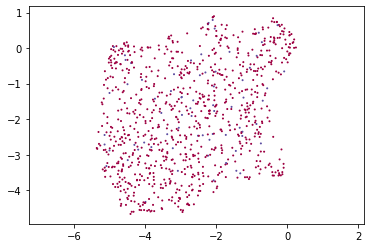

In [5]:
import umap
reducer = umap.UMAP(random_state=369)
umap_embedding = reducer.fit_transform(X_data_one_hot)
plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=y_data.values.astype(int), s=1, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')

C:\Users\USER\anaconda3\envs\reStroke\lib\site-packages\umap\umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


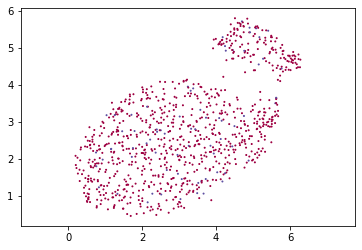

In [6]:
reducer = umap.UMAP(metric = heom_metric.heom, random_state=369)
umap_heom_embedding = reducer.fit_transform(X_data)
plt.scatter(
    umap_heom_embedding[:, 0],
    umap_heom_embedding[:, 1],
    c=y_data.values.astype(int), s=1, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')

# T-SNE

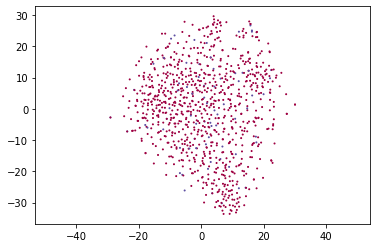

In [7]:
from sklearn.manifold import TSNE
tsne_embedding = TSNE(n_components=2, perplexity=30, random_state=369).fit_transform(X_data_one_hot)
plt.scatter(
    tsne_embedding[:, 0],
    tsne_embedding[:, 1],
    c=y_data.values.astype(int), s=1, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')


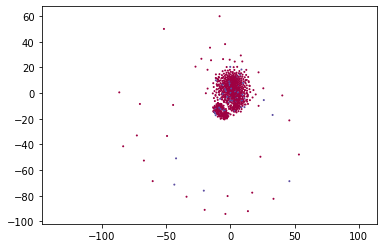

In [8]:
tsne_heom_embedding = TSNE(n_components=2, perplexity=30, metric = heom_metric.heom, random_state=369).fit_transform(X_data)
plt.scatter(
    tsne_heom_embedding[:, 0],
    tsne_heom_embedding[:, 1],
    c=y_data.values.astype(int), s=1, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')

## Add cluster labels

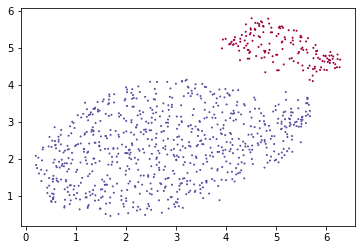

In [9]:
# import hdbscan
# umap_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=50).fit_predict(umap_heom_embedding)

from sklearn.cluster import DBSCAN
umap_labels = DBSCAN(eps=0.3, min_samples=5).fit_predict(umap_heom_embedding)

clustered = (umap_labels >= 0)
plt.scatter(umap_heom_embedding[clustered, 0],
            umap_heom_embedding[clustered, 1],
            c=umap_labels[clustered],
            s=1,
            cmap='Spectral');
tidy_data['umap_label'] = umap_labels

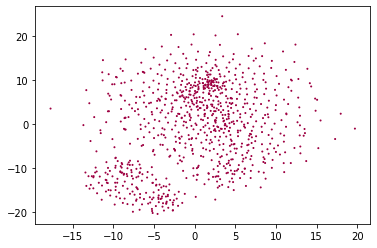

In [10]:
# tsne_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=50).fit_predict(tsne_heom_embedding)
tsne_labels = DBSCAN(eps=5, min_samples=5).fit_predict(tsne_heom_embedding)
clustered = (tsne_labels >= 0)
plt.scatter(tsne_heom_embedding[clustered, 0],
            tsne_heom_embedding[clustered, 1],
            c=tsne_labels[clustered],
            s=1,
            cmap='Spectral');
tidy_data['tsne_labels'] = tsne_labels

In [11]:
label_diff = umap_labels - tsne_labels
print('diff %.2f%%' %(len(label_diff[label_diff !=0])/len(label_diff)*100))

diff 82.85%


In [12]:
tidy_data.to_csv('cluster_result.csv', index=False)